In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy import signal

import video

In [2]:
vid = video.Video("ORBCOMM-2 Full Launch Webcast-O5bTbVbe4e4.webm")

In [3]:
# times
f_launch = 41469 # first frame of "t-plus"
f_100km = 46339 # altitude format switches at 100 km

# digit locations
rloc_alt = [(210, 240), (1768, 1845)]
rloc_vel = [(210, 240), (1560, 1670)]
rloc_time = [(32, 62), (1510, 1750)]

def slicify(ranges):
    return tuple(slice(*r) for r in ranges)

loc_alt = slicify(rloc_alt)
loc_vel = slicify(rloc_vel)
loc_time = slicify(rloc_time)

In [4]:
frame = vid.f[f_launch]
frame.data.shape

(1080, 1920)

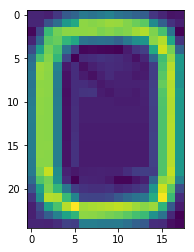

In [5]:
digit = slice(214, 239), slice(1626, 1644)
zero = vid.f[f_launch].data[digit]
plt.imshow(zero, interpolation='nearest')

In [6]:
zero.shape

(25, 18)

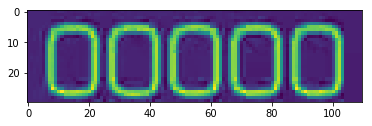

In [7]:
plt.imshow(vid.f[f_launch].data[loc_vel])

In [8]:
vel_digits = vid.f[f_launch].data[loc_vel]

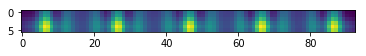

In [9]:
conv = signal.convolve2d(vel_digits, zero, mode='valid')
plt.imshow(conv)

In [10]:
max_list = []
for _ in range(10):
    max_list.append(ndimage.maximum_position(conv))
    conv[max_list[-1]] = 0

In [11]:
max_list[:5]

[(4, 46), (4, 66), (4, 26), (4, 6), (4, 86)]

In [12]:
digit_size = zero.shape

In [13]:
locs = np.array([x[0] for x in rloc_vel]) + max_list[:5]

In [14]:
locs.sort(axis=0)
locs

array([[ 214, 1566],
       [ 214, 1586],
       [ 214, 1606],
       [ 214, 1626],
       [ 214, 1646]])

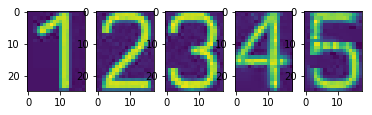

In [15]:
slocs = []
for loc in locs:
    x, y = loc
    w, h = digit_size
    slocs.append(slicify([(x, x+w), (y, y+h)]))
    
onetwothreefourfive = f_launch + 13308    
frame = vid.f[onetwothreefourfive]
f, axs = plt.subplots(1, 5)
for ax, sloc in zip(axs, slocs):
    ax.imshow(frame.data[sloc])

A bit of searching for all the digits...

In [16]:
examples = [
    {'digit': '0', 'frame': f_launch, 'position': 0},
    {'digit': '1', 'frame': f_launch + 13308, 'position': 0},
    {'digit': '2', 'frame': f_launch + 13308, 'position': 1},
    {'digit': '3', 'frame': f_launch + 3500, 'position': 1},
    {'digit': '4', 'frame': f_launch + 1000, 'position': 4},
    {'digit': '5', 'frame': f_launch + 6000, 'position': 1},
    {'digit': '6', 'frame': f_launch + 3000, 'position': 3},
    {'digit': '7', 'frame': f_launch + 6000, 'position': 4},
    {'digit': '8', 'frame': f_launch + 7000, 'position': 4},
    {'digit': '9', 'frame': f_launch + 3000, 'position': 4},
]
for ex in examples:
    ex['prototype'] = vid.f[ex['frame']].data[slocs[ex['position']]]
    ex['mask'] = ex['prototype'] > 0.5
    ex['prototype'] = ex['prototype'] / ex['prototype'].sum()

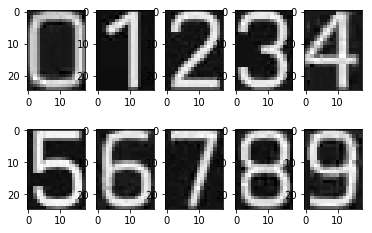

In [17]:
f, axs = plt.subplots(2, 5)
for ax, ex in zip(axs.flat, examples):
    ax.imshow(ex['prototype'], interpolation='nearest', cmap='gray')

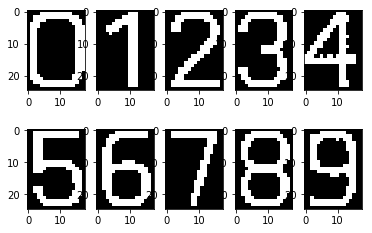

In [18]:
f, axs = plt.subplots(2, 5)
for ax, ex in zip(axs.flat, examples):
    ax.imshow(ex['mask'], interpolation='nearest', cmap='gray')

## ML Methods?

In [19]:
import skimage.transform

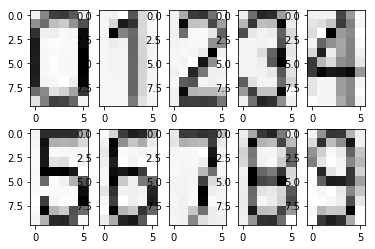

In [20]:
f, axs = plt.subplots(2, 5)
for ax, ex in zip(axs.flat, examples):
    ax.imshow(skimage.transform.resize(ex['prototype'], (10, 6)), interpolation='nearest', cmap='gray_r')

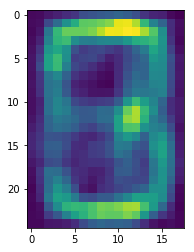

In [21]:
f, ax = plt.subplots()
merge = np.sum(np.array([ex['prototype'] for ex in examples]), axis=0) / 10
ax.imshow(merge)

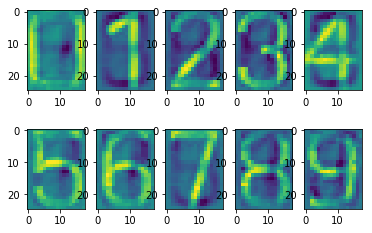

In [22]:
f, axs = plt.subplots(2, 5)
for ax, ex in zip(axs.flat, examples):
    ax.imshow(ex['prototype'] - merge)

In [23]:
def percentile_threshold(data, q):
    thold = np.percentile(data, q)
    return data > thold

def compare_correlate(digit):
    digit = percentile_threshold(digit, 75)
    
    return np.argmax([signal.correlate(
                digit,
                # (255 * (num['prototype'] - 0.5 * merge)).astype('uint8'),
                # percentile_threshold(num['prototype'], 75).astype(int),
                num['prototype'],
                mode='valid')
            for num 
            in examples])

def compare_xor(digit, all=False):
    digit = digit > 0.5
    values = [np.bitwise_xor(digit, num['mask']).sum() for num in examples]
    if all:
        return values
    return np.argmin(values)

In [24]:
compare_xor(vid.f[42739].data[slocs[0]], all=True) # should have 0th as highest

[7, 214, 138, 124, 225, 122, 142, 168, 129, 138]

In [25]:
compare_xor(vid.f[onetwothreefourfive].data[slocs[4]], all=True) # should be index 5

[127, 176, 124, 104, 189, 14, 48, 144, 79, 102]

In [26]:
def read(vid, f):
    frame = vid.f[f].data
    result = 0
    for n_digit, sloc in enumerate(slocs):
        digit = frame[sloc]
        result *= 10
        result += compare_xor(digit)
    return result

In [27]:
read(vid, onetwothreefourfive)

12345

In [28]:
test_frames = np.random.randint(50000, 59000, size=20)
test_frames.sort()
test_frames

array([50082, 50303, 50397, 50976, 51024, 51040, 51692, 52265, 52683,
       52778, 52853, 53525, 54088, 54260, 54363, 54722, 55176, 55260,
       56966, 58712])

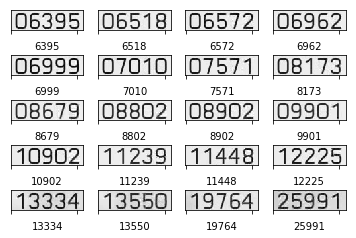

In [29]:
f, axs = plt.subplots(5, 4)
for ax, fr in zip(axs.flat, test_frames):
    ax.imshow(vid.f[fr].data[loc_vel], interpolation='nearest', cmap='gray_r')
    ax.xaxis.set_ticklabels([])
    ax.set_xlabel(str(read(vid, fr)))
    ax.yaxis.set_visible(False)

## OpenCV methods?

In [30]:
import cv2

In [31]:
def find_contours(img):
    image, contours, hier = cv2.findContours((img * 255).astype('uint8'), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    return contours, hier

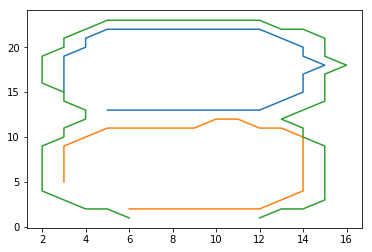

In [32]:
conts = find_contours(examples[8]['prototype'])
f, ax = plt.subplots()
for cont in conts[0]:
    cont = cont.reshape(-1, 2)
    ax.plot(*cont.T)